In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


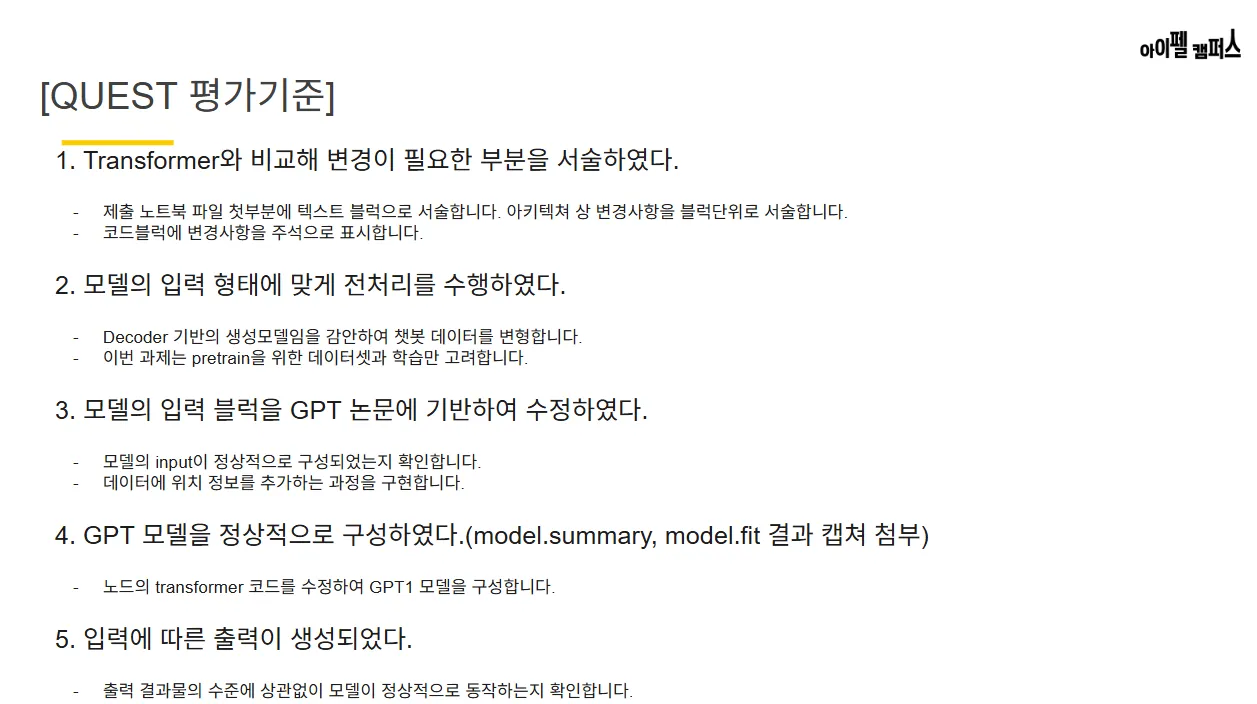

#### 1. Transformer와 비교해 변경이 필요한 부분을 서술하였다.
---
- 제출 노트북 파일 첫부분에 텍스트 블럭으로 서술합니다. 아키텍쳐 상 변경사항을 블럭단위로 서술합니다.
- 코드블럭에 변경사항을 주석으로 표시합니다.

In [2]:
# 디코더에서 Positional Encoding -> Positional Embeding layer
# 따라서 복잡한 수식이 사라지고, 학습이 가능한 임베딩으로 변경된다.

In [3]:
# 인코더와 디코더 중에 인코더 부분 (셀프어텐션 + 피드포워드)이 사라진다.
# 따라서 인코더 디코너 어텐션이 사라진다.

In [4]:
# GPT-1은 다양한 NLP 작업에 적용된다. "task-aware input transformations" 
# 텍스트 분류, 함의, 유사성, 질문 응답 등을 위한 입력 변환이 추가된다.

In [5]:
# 대규모 비지도 사전학습 단계(와 특정 작업용 지도 미세조정 단계인 2단계로 나뉜)다.
# 인코더의 input값은 디코더의 input값과 합쳐져서 디코더의 입력으로 들어간다.

#### 2. 모델의 입력 형태에 맞게 전처리를 수행하였다.
---
- Decoder기반의 생성모델임을 감안하여 챗봇 데이터를 변형합니다.
- 이번 과제는 pretrain을 위한 데이터셋과 학습만 고려합니다.

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("슝=3")
path_to_csv = tf.keras.utils.get_file(
    'ChatbotData.csv',
    origin='https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv',
    extract=False)
path_to_chatbot_data = path_to_csv
print("슝=3")
# CSV 파일 읽어서 확인
chatbot_data = pd.read_csv(path_to_chatbot_data)
print(f"데이터 샘플 확인:\n{chatbot_data.head()}")
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 10000
print(MAX_SAMPLES)
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence의 양쪽 공백을 제거
  sentence = sentence.strip()
  
  # 단어와 구두점 사이의 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  
  # 한글, 영문자, 구두점을 제외한 모든 문자를 공백으로 대체
  sentence = re.sub(r'[^가-힣a-zA-Z.?!,]+', " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")
# GPT 스타일 사전학습을 위한 텍스트 코퍼스 생성 함수
def create_pretrain_corpus():
  corpus = []
  
  # 각 행의 질문과 답변을 하나의 연속된 텍스트로 연결
  for idx, row in chatbot_data.iterrows():
    q = preprocess_sentence(row['Q'])
    a = preprocess_sentence(row['A'])
    
    # GPT-1 스타일: 연속적인 텍스트로 질문과 응답을 연결
    # 특수 구분자로 구분하여 하나의 텍스트 블록으로 만듦
    combined_text = q + " [SEP] " + a + " [EOS]"
    corpus.append(combined_text)
    
    if len(corpus) >= MAX_SAMPLES:
      break
  
  return corpus
print("슝=3")
# 사전학습용 코퍼스 생성
pretrain_corpus = create_pretrain_corpus()
print(f"사전학습 코퍼스 크기: {len(pretrain_corpus)}")
print(f"사전학습 코퍼스 샘플:\n{pretrain_corpus[21]}")

슝=3
슝=3
데이터 샘플 확인:
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0
10000
슝=3
슝=3
사전학습 코퍼스 크기: 10000
사전학습 코퍼스 샘플:
가스비 장난 아님 [SEP] 다음 달에는 더 절약해봐요 . [EOS]


#### 3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정하였다.
---
- 모델의 input이 정상적으로 구성되었는지 확인합니다.
- 데이터의 위치 정보를 추가하는 과정을 구현합니다.

In [7]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 사전학습 코퍼스를 기반으로 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    pretrain_corpus, target_vocab_size=2**13)
print("슝=3 ")

# 특수 토큰들에 고유한 정수를 부여합니다
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
SEP_TOKEN, EOS_TOKEN = [tokenizer.vocab_size + 2], [tokenizer.vocab_size + 3]
print("슝=3")

print('START_TOKEN의 번호 :', START_TOKEN)
print('END_TOKEN의 번호 :', END_TOKEN)
print('SEP_TOKEN의 번호 :', SEP_TOKEN)
print('EOS_TOKEN의 번호 :', EOS_TOKEN)

# 특수 토큰들을 고려하여 +4를 하여 단어장의 크기를 산정합니다
VOCAB_SIZE = tokenizer.vocab_size + 4
print("단어장 크기:", VOCAB_SIZE)

# 임의의 샘플에 대해서 정수 인코딩 작업을 수행
print('정수 인코딩 후의 21번째 코퍼스 샘플:')
sample_text = pretrain_corpus[21]
encoded_sample = tokenizer.encode(sample_text)
print(encoded_sample)

# GPT-1 스타일 학습을 위한 최대 시퀀스 길이 설정
MAX_LENGTH = 128
print("최대 시퀀스 길이:", MAX_LENGTH)

# GPT-1 스타일의 언어 모델링을 위한 데이터셋 준비 함수
def create_gpt_datasets(corpus, seq_length=MAX_LENGTH):
    # 모든 텍스트를 토큰화하고 특수 토큰을 수동으로 처리
    all_encoded_texts = []
    
    for text in corpus:
        # 텍스트를 "[SEP]"와 "[EOS]" 토큰 기준으로 분할
        parts = text.split(" [SEP] ")
        if len(parts) == 2:
            q_part, a_part = parts
            
            # "[EOS]" 토큰 제거
            a_part = a_part.replace(" [EOS]", "")
            
            # 각 부분을 개별적으로 인코딩
            q_encoded = tokenizer.encode(q_part)
            a_encoded = tokenizer.encode(a_part)
            
            # 특수 토큰과 함께 수동으로 시퀀스 구성
            full_sequence = START_TOKEN + q_encoded + SEP_TOKEN + a_encoded + EOS_TOKEN + END_TOKEN
            all_encoded_texts.append(full_sequence)
    
    # 너무 긴 시퀀스는 필터링
    filtered_texts = [seq for seq in all_encoded_texts if len(seq) <= seq_length]
    
    print(f"필터링 후 시퀀스 수: {len(filtered_texts)}")
    
    # 입력과 타겟 분리 (GPT 스타일: 입력 시퀀스와 1칸씩 이동한 타겟)
    inputs, targets = [], []
    
    for seq in filtered_texts:
        inputs.append(seq[:-1])  # 마지막 토큰 제외
        targets.append(seq[1:])  # 첫 토큰 제외
    
    # 텐서로 변환하고 패딩 적용
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(
        inputs, maxlen=seq_length-1, padding='post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(
        targets, maxlen=seq_length-1, padding='post')
    
    return input_tensor, target_tensor

# GPT 스타일 데이터셋 생성
input_tensor, target_tensor = create_gpt_datasets(pretrain_corpus)

# 모델 입력이 정상적으로 구성되었는지 확인
print("\n입력 텐서 형태:", input_tensor.shape)
print("타겟 텐서 형태:", target_tensor.shape)
print("\n입력 예시 (첫 번째 시퀀스):", input_tensor[0][:10], "...")
print("타겟 예시 (첫 번째 시퀀스):", target_tensor[0][:10], "...")

# TensorFlow 데이터셋 생성
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 데이터셋이 올바르게 구성되었는지 확인
for input_example, target_example in dataset.take(1):
    print("\n데이터셋 첫 번째 배치 형태:")
    print("입력 배치 형태:", input_example.shape)
    print("타겟 배치 형태:", target_example.shape)
print("슝=3")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 
슝=3
START_TOKEN의 번호 : [8821]
END_TOKEN의 번호 : [8822]
SEP_TOKEN의 번호 : [8823]
EOS_TOKEN의 번호 : [8824]
단어장 크기: 8825
정수 인코딩 후의 21번째 코퍼스 샘플:
[8537, 3645, 7123, 5, 3, 2, 1767, 5685, 11, 4726, 119, 1, 4, 8658]
최대 시퀀스 길이: 128
필터링 후 시퀀스 수: 10000

입력 텐서 형태: (10000, 127)
타겟 텐서 형태: (10000, 127)

입력 예시 (첫 번째 시퀀스): [8821 3074 4065 8597 8598 8823 2790   64 5997 8597] ...
타겟 예시 (첫 번째 시퀀스): [3074 4065 8597 8598 8823 2790   64 5997 8597 8611] ...

데이터셋 첫 번째 배치 형태:
입력 배치 형태: (64, 127)
타겟 배치 형태: (64, 127)
슝=3


#### 4. GPT 모델을 정상적으로 구성하였다.(model.summary, model.fit 결과 캡쳐 첨부)
---
- 노드의 transformer 코드를 수정하여 GPT1 모델을 구성합니다.

슝=3
Model: "gpt_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (2,)                 0           inputs[0][0]                     
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici ()                   0           tf.compat.v1.shape[0][0]         
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 768)    6777600     inputs[0][0]                     
______________________________________________________________________________________

313/313 [==============================] - 285s 865ms/step - loss: 7.4185 - accuracy: 0.1468
Epoch 2/5
313/313 [==============================] - 272s 869ms/step - loss: 5.6684 - accuracy: 0.3469
Epoch 3/5
313/313 [==============================] - 272s 869ms/step - loss: 5.2834 - accuracy: 0.3516
Epoch 4/5
313/313 [==============================] - 272s 869ms/step - loss: 5.0598 - accuracy: 0.3576
Epoch 5/5
313/313 [==============================] - 272s 869ms/step - loss: 4.8955 - accuracy: 0.3636
모델 학습 완료!


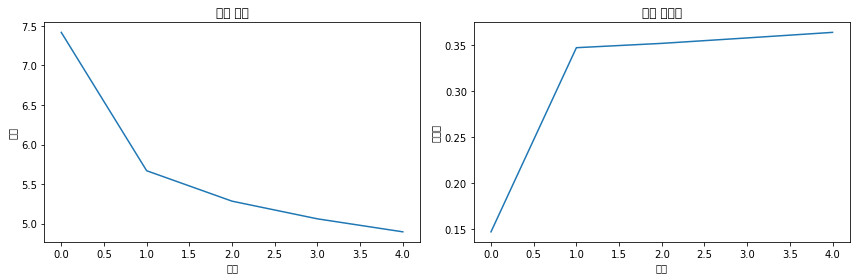

In [13]:
def gpt_model(vocab_size,
              num_layers,
              units,
              d_model,
              num_heads,
              dropout,
              max_position_encoding,
              name="gpt_model"):
  """
  GPT-1 모델 구현 - 디코더 전용 트랜스포머 모델
  """
  # 입력 텐서
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  
  # 마스크 생성 - 미래 토큰을 마스킹
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(inputs)
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  
  # 학습 가능한 포지셔널 임베딩 (GPT-1 논문에 명시된 대로)
  position_embedding = tf.keras.layers.Embedding(
      input_dim=max_position_encoding,
      output_dim=d_model,
      name="position_embedding"
  )(tf.range(tf.shape(inputs)[1]))
  
  # 임베딩과 포지셔널 임베딩 합치기
  x = embeddings + position_embedding
  
  # 드롭아웃 적용
  x = tf.keras.layers.Dropout(rate=dropout)(x)
  
  # 디코더 레이어 스택 쌓기
  for i in range(num_layers):
    # 첫 번째 서브 레이어: 마스크드 셀프 어텐션
    attn_output = MultiHeadAttention(
        d_model, num_heads, name=f"attention_{i}")(inputs={
            'query': x,
            'key': x,
            'value': x,
            'mask': look_ahead_mask
        })
    
    # 드롭아웃 및 레이어 정규화 (잔차 연결 포함)
    attn_output = tf.keras.layers.Dropout(rate=dropout)(attn_output)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
    
    # 두 번째 서브 레이어: 피드포워드 신경망
    # GELU 활성화 함수 사용 (GPT-1 논문에 명시)
    ffn_output = tf.keras.layers.Dense(units=units, activation=gelu)(x)
    ffn_output = tf.keras.layers.Dense(units=d_model)(ffn_output)
    
    # 드롭아웃 및 레이어 정규화 (잔차 연결 포함)
    ffn_output = tf.keras.layers.Dropout(rate=dropout)(ffn_output)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)
  
  # 최종 출력 레이어
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(x)
  
  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

# GELU 활성화 함수 구현 (GPT-1에서 사용)
def gelu(x):
    """
    Gaussian Error Linear Unit (GELU) 활성화 함수
    GPT-1 논문에서 사용됨
    """
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

print("슝=3")

# 하이퍼파라미터 - GPT-1 논문 기준으로 설정
tf.keras.backend.clear_session()

# GPT-1 하이퍼파라미터
NUM_LAYERS = 12  # 논문: 12-layer decoder
D_MODEL = 768    # 논문: 768 dimensional states
NUM_HEADS = 12   # 논문: 12 attention heads
UNITS = 3072     # 논문: 3072 dimensional inner states for FFN
DROPOUT = 0.1    # 논문: residual, embedding, and attention dropouts with a rate of 0.1
MAX_POSITION = 512  # 논문: contiguous sequences of 512 tokens

# GPT-1 모델 구성
model = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_position_encoding=MAX_POSITION)

# 모델 요약 출력
model.summary()

# 손실 함수 수정 - GPT 언어 모델링용
def loss_function(y_true, y_pred):
    # 패딩 토큰은 손실 계산에서 제외
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    
    # 크로스 엔트로피 손실 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    # 마스크 적용
    loss = loss * mask
    
    # 평균 손실 반환
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

# 정확도 함수 수정
def accuracy(y_true, y_pred):
    # 패딩 토큰은 정확도 계산에서 제외
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    
    # 예측 값 선택
    pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)
    
    # 정확도 계산
    correct = tf.cast(tf.equal(pred, tf.cast(y_true, tf.int32)), tf.float32)
    
    # 마스크 적용하여 패딩 제외
    correct = correct * mask
    
    # 평균 정확도 반환
    return tf.reduce_sum(correct) / tf.reduce_sum(mask)

# 학습률 스케줄 설정
learning_rate = CustomSchedule(D_MODEL, warmup_steps=10000)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# GPT 데이터셋 형식 재정의 - 입력과 타겟을 재구성
gpt_dataset = tf.data.Dataset.from_tensor_slices((
    input_tensor,  # 입력
    target_tensor  # 타겟 (다음 토큰)
))

gpt_dataset = gpt_dataset.cache()
gpt_dataset = gpt_dataset.shuffle(BUFFER_SIZE)
gpt_dataset = gpt_dataset.batch(BATCH_SIZE)
gpt_dataset = gpt_dataset.prefetch(tf.data.experimental.AUTOTUNE)

print("슝=3")

# 모델 학습
print("모델 학습 시작...")
EPOCHS = 5  # 시간 관계상 에폭 수 감소
history = model.fit(gpt_dataset, epochs=EPOCHS, verbose=1)
print("모델 학습 완료!")

# 학습 결과 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('모델 손실')
plt.ylabel('손실')
plt.xlabel('에폭')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('모델 정확도')
plt.ylabel('정확도')
plt.xlabel('에폭')

plt.tight_layout()
plt.show()

#### 5. 입력에 따른 출력이 생성되었다
---
- 출력 결과물의 수준에 상관없이 모델이 정상적으로 동작하는지 확인합니다.

In [19]:
def gpt_inference(sentence, max_length=40):
    """
    GPT-1 모델을 사용하여 입력 문장에 이어지는 텍스트를 생성하는 함수
    """
    # 문장 전처리
    sentence = preprocess_sentence(sentence)
    
    # 입력 문장을 정수 인코딩하고 시작 토큰 추가
    input_sequence = START_TOKEN + tokenizer.encode(sentence)
    
    # 텐서로 변환
    input_tensor = tf.convert_to_tensor([input_sequence], dtype=tf.int32)
    
    # 출력 시퀀스 초기화 (입력 시퀀스와 동일하게 시작)
    output_sequence = input_sequence.copy()
    
    # 자동 회귀(auto-regressive) 생성 과정
    for i in range(max_length):
        # 현재까지의 출력 시퀀스로 다음 토큰 예측
        output_tensor = tf.convert_to_tensor([output_sequence], dtype=tf.int32)
        predictions = model(output_tensor, training=False)
        
        # 마지막 토큰에 대한 예측값 가져오기
        predictions = predictions[:, -1:, :]
        
        # 다음 토큰 예측 (가장 확률이 높은 토큰 선택)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # 예측된 토큰을 출력 시퀀스에 추가
        output_sequence = output_sequence + predicted_id.numpy().tolist()[0]
        
        # 종료 토큰이 예측되면 생성 중단
        if predicted_id.numpy()[0][0] == END_TOKEN[0]:
            break
    
    # 특수 토큰 제거하고 텍스트로 디코딩
    output_sequence = [token for token in output_sequence if token < tokenizer.vocab_size]
    output_text = tokenizer.decode(output_sequence)
    
    return output_text

def sentence_generation(sentence):
    """
    입력 문장에 대한 응답을 생성하고 출력하는 함수
    """
    # 모델이 문장을 이어서 생성하도록 함
    generated_text = gpt_inference(sentence)
    
    print('입력: {}'.format(sentence))
    print('출력: {}'.format(generated_text))
    
    return generated_text

print("슝=3")
# 한국어 문장으로 테스트
sentence_generation('너는 어디에 있었어요?')
sentence_generation("그건 함정이에요.")

슝=3
입력: 너는 어디에 있었어요?
출력: 너는 어디에 있었어요 ?좋은 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 있을 거예요 .
입력: 그건 함정이에요.
출력: 그건 함정이에요 .좋은 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 있을 거예요 .


'그건 함정이에요 .좋은 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 더 있을 거예요 .'